In [357]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [2]:
%config Completer.use_jedi = False

In [377]:
train = pd.read_csv("/Users/sergmiller/Downloads/train.csv")
edu = pd.read_csv("/Users/sergmiller/Downloads/trainEducationFeatures.csv")
groups =  pd.read_csv("/Users/sergmiller/Downloads/trainGroups.csv")
friends =  pd.read_csv("/Users/sergmiller/Downloads/friends.csv")

In [56]:
np.mean(train['registered_year'])

2013.7580508330789

In [74]:
np.corrcoef(train['registered_year'].values, train['age'].values)

array([[ 1.        , -0.09645648],
       [-0.09645648,  1.        ]])

(array([ 215., 1516., 5647., 3314., 4802., 1981., 3671., 1731., 3629.,
        2963.]),
 array([2006. , 2007.5, 2009. , 2010.5, 2012. , 2013.5, 2015. , 2016.5,
        2018. , 2019.5, 2021. ]),
 <BarContainer object of 10 artists>)

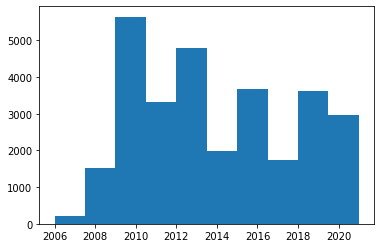

In [73]:
plt.hist(train['registered_year'])

In [100]:
from sklearn.linear_model import LinearRegression

In [158]:
max(train['age'])

89

In [176]:
edu.shape, train.shape

((29469, 9), (29469, 3))

In [412]:
edu_with_register = pd.merge(edu[~pd.isnull(edu['school_education'])], train, how='left', on='uid')

In [413]:
edu_with_register

,uid,school_education,graduation_1,graduation_2,graduation_3,graduation_4,graduation_5,graduation_6,graduation_7,age,registered_year
0,30288,2008.0,NaN,NaN,NaN,NaN,2013.0,NaN,NaN,30,2008
1,25275,2007.0,NaN,NaN,NaN,NaN,NaN,2011.0,NaN,31,2007
2,116156,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,2010
3,10794,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,34,2010
4,99780,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,2012
...,...,...,...,...,...,...,...,...,...,...,...
9109,90272,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,2012
9110,33331,1987.0,NaN,NaN,NaN,NaN,1991.0,NaN,NaN,51,2008
9111,97581,2002.0,NaN,NaN,NaN,NaN,2007.0,NaN,NaN,36,2010
9112,104038,1969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,2013


In [414]:
edu_with_g5 = pd.merge(edu[~pd.isnull(edu['graduation_5'])], train, how='left', on='uid')

In [417]:
edu_with_g5_and_reg = pd.merge(edu[~pd.isnull(edu['graduation_5'])][~pd.isnull(edu['school_education'])], train, how='left', on='uid')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [419]:
edu_with_g5_and_reg.shape

(1268, 11)

In [420]:
model = LinearRegression()
model.fit(edu_with_g5_and_reg[['registered_year', 'school_education', 'graduation_5']], edu_with_g5_and_reg['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.06561199, -0.82945563, -0.12746959]), 1821.0781979242786)

In [415]:
model = LinearRegression()
model.fit(edu_with_g5[['registered_year', 'graduation_5']], edu_with_g5['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([ 0.2681817 , -0.89100903]), 1287.6021512433363)

In [184]:
model = LinearRegression()
model.fit(edu_with_register[['registered_year', 'school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.05582762, -0.88421684]), 1918.9770112931192)

In [196]:
model = LinearRegression()
model.fit(edu_with_register[['school_education']], edu_with_register['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.88518542]), 1808.6193469773386)

In [105]:
model = LinearRegression()
model.fit(train[['registered_year', 'school']], train['age'].values.reshape(-1))
model.coef_, model.intercept_

(array([-0.32882735]), 697.2078772973922)

In [ ]:
model.predict()

In [363]:
def decision(school: float, register: float, groups: list):
    if np.isnan(school):
        r = 697.208 - 0.32883 * register  # approx 35
    else:
#         r = 2021 - school + 18
        r = 1918.977 - 0.05583 * register - 0.88422 * school
#         r = 1808.62 - 0.88519 * school
    r = max(r, 14)
    r = min(89, r)
    return r


def make_predictions(ids: pd.DataFrame, education: pd.DataFrame, groups: pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame()
    result['uid'] = ids['uid']
    school = {uid : year for uid, year in zip(education['uid'].values, education['school_education'].values)}
    register = {uid : year for uid, year in zip(ids['uid'].values, ids['registered_year'].values)}
    groups_list = defaultdict(list)
    for uid, gid in zip(groups['uid'].values, groups['gid'].values):
        groups_list[uid].append(gid)
    result['age'] = [decision(school[uid], register[uid], groups_list[uid]) for uid in result['uid'].values]
    assert result.shape[0] == ids.shape[0] and result.shape[1] == 2
    assert ['uid', 'age'] == list(result.columns)
    return result

In [364]:
res = make_predictions(train, edu, groups)

In [360]:
np.mean((res['age'] - train['age']) ** 2) ** 0.5

11.541098370410738

In [19]:
result.to_csv('/Users/sergmiller/Downloads/result.csv', index=None, index_label=None)

In [23]:
np.mean(train['age'].values)

35.02914927550986

In [17]:
list(result.columns)

['uid', 'age']

In [ ]:
np.mean(train['age'].values)

In [304]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [243]:
user_weights = groups.groupby('uid').gid.nunique()
user2weight = {u:w for u,w in zip(user_weights.index.values, user_weights.values)}

In [305]:
row = groups['gid'].values
col = groups['uid'].values
data = [user2weight[u] for u in col]

(array([1.784e+03, 1.130e+03, 8.550e+02, 7.280e+02, 7.080e+02, 6.500e+02,
        6.140e+02, 5.250e+02, 5.000e+02, 5.270e+02, 4.330e+02, 4.150e+02,
        2.970e+02, 4.240e+02, 3.910e+02, 3.470e+02, 3.270e+02, 3.050e+02,
        2.900e+02, 3.050e+02, 2.970e+02, 3.000e+02, 2.530e+02, 2.820e+02,
        1.690e+02, 2.260e+02, 2.400e+02, 2.170e+02, 2.520e+02, 2.020e+02,
        1.840e+02, 1.850e+02, 2.000e+02, 6.029e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.92,   6.84,   9.76,  12.68,  15.6 ,  18.52,  21.44,
         24.36,  27.28,  30.2 ,  33.12,  36.04,  38.96,  41.88,  44.8 ,
         47.72,  50.64,  53.56,  56.48,  59.4 ,  62.32,  65.24,  68.16,
         71.08,  74.  ,  76.92,  79.84,  82.76,  85.68,  88.6 ,  91.52,
         94.44,  97.36, 100.28, 103.2 , 106.12, 109.04, 111.96, 114.88,
        117.8 , 

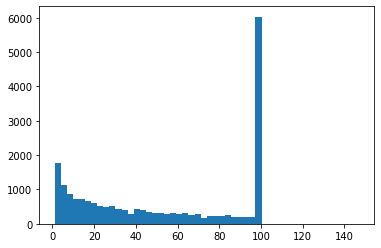

In [375]:
plt.hist(user_weights.values, bins=50)

In [276]:
max(row), max(col)

(362032, 120055)

In [306]:
train_g2u = csr_matrix((data, (row, col)), shape=(362033, 120056))

In [307]:
als = AlternatingLeastSquares(factors=32, random_state=0)
als.fit(train_g2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [308]:
als.item_factors.shape

(362033, 32)

In [309]:
als.user_factors.shape

(120056, 32)

In [310]:
from sklearn.neighbors import KNeighborsRegressor

In [311]:
N = 10000

In [312]:
user_embs_for_knn = np.array([als.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn.shape, knn_age.shape

((29469, 32), (29469,))

In [321]:
def calc_embedding_by_user_groups(user_groups: np.array):
    groups_embeds = als.item_factors[user_groups]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [376]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 28.7 s, sys: 7.59 s, total: 36.3 s
Wall time: 16.7 s


7.627103383099767

In [344]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn[:N], knn_age[:N])

knn_age_predicted = knn.predict(user_embs_for_knn[N:])

res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
res

CPU times: user 6.41 s, sys: 1.9 s, total: 8.32 s
Wall time: 3.66 s


10.719051118447588

In [348]:
pd.read_csv('../submision/data/train_groups.csv').values.shape

(160831, 1)

In [326]:
known_groups = np.unique(groups['gid'].values)

In [329]:
pd.DataFrame(known_groups).to_csv("../submision/data/train_groups.csv", index=None, index_label=None)

In [330]:
user_embs_for_knn.shape

(29469, 32)

In [331]:
train['uid'].shape

(29469,)

In [332]:
pd.DataFrame(train).to_csv("../submision/data/train.csv", index=None, index_label=None)

In [336]:
pd.DataFrame(user_embs_for_knn).to_csv("../submision/data/train_als_user_embeddings.csv", index=None, index_label=None)

In [340]:
group_embds_for_knn = als.item_factors[known_groups]

In [341]:
group_embds_for_knn.shape

(160831, 32)

In [339]:
user_embs_for_knn.shape

(29469, 32)

In [342]:
pd.DataFrame(group_embds_for_knn).to_csv("../submision/data/train_als_group_embeddings.csv", index=None, index_label=None)

In [345]:
als.item_factors[[1,2]]

array([[-0.03352285,  0.01173679, -0.00479133, -0.00079793,  0.00691519,
         0.02763588, -0.00387738, -0.02486044, -0.00412413, -0.01828809,
         0.03304713,  0.00094347,  0.03785113, -0.00548973,  0.00034857,
        -0.02208665,  0.00284895,  0.03267703, -0.00689618,  0.02914728,
         0.01545629,  0.01312421,  0.01298617,  0.01491231, -0.01607238,
        -0.00461709, -0.00313677,  0.00893403,  0.01912749,  0.04901997,
        -0.00721672,  0.02671472],
       [ 0.01577521, -0.00342512, -0.03403663, -0.00619824, -0.01844874,
         0.02002376, -0.01083123, -0.01982027, -0.02211998,  0.02357365,
         0.02775149,  0.00207958,  0.00818852,  0.0136739 ,  0.01661555,
         0.00561788, -0.01665961, -0.01122996, -0.00927404, -0.0091855 ,
         0.01583714,  0.01119312,  0.01644872, -0.00017456,  0.01745618,
         0.00827894,  0.00624486,  0.00029817,  0.00274924,  0.02194361,
         0.00729352,  0.02449917]], dtype=float32)

In [368]:
pd.read_csv('../submision/data/train_als_user_embeddings.csv').values

array([[ 0.00620317,  0.01065773, -0.01442813, ...,  0.02823488,
         0.02111417,  0.0143768 ],
       [ 0.6269256 , -0.19519456,  0.26703796, ...,  0.19338019,
         0.8778059 , -0.30893627],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02584702,  0.06221347, -0.00454262, ...,  0.01528523,
         0.01898878,  0.09596544],
       [-0.5718822 ,  0.6594821 ,  0.07554404, ..., -1.6461611 ,
         0.64993376, -1.061764  ]])

In [380]:
friends2way = pd.DataFrame()
friends2way['uid'] = list(friends['uid']) + list(friends['fuid'])
friends2way['fuid'] = list(friends['fuid']) + list(friends['uid'])

In [381]:
friends2way.shape

(8219754, 2)

In [383]:
friend_weights = friends2way.groupby('uid').fuid.nunique()
friend2weight = {u:w for u,w in zip(friend_weights.index.values, friend_weights.values)}

In [387]:
rowf = friends2way['fuid'].values
colf = friends2way['uid'].values
dataf = [friend2weight[u] for u in colf]

(array([7.1364e+04, 2.3933e+04, 1.0380e+04, 2.4480e+03, 6.8500e+02,
        3.7100e+02, 2.3300e+02, 2.0600e+02, 1.2700e+02, 9.4000e+01,
        7.8000e+01, 7.3000e+01, 5.8000e+01, 4.5000e+01, 4.2000e+01,
        2.8000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.2000e+01,
        2.1000e+01, 7.0000e+00, 1.0000e+01, 1.0000e+01, 1.0000e+01,
        7.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000e+00, 5.55200e+01, 1.10040e+02, 1.64560e+02, 2.19080e+02,
        2.73600e+02, 3.28120e+02, 3.82640e+02, 4.37160e+02, 4.91680e+02,
        5.46200e+02, 6.00720e+02, 6.55240e+02, 7.09760e+02, 7.64280e+02,
        8.18800e+02, 8.73320e+02, 9.27840e+02, 9.82360e+02, 1.03688e+03,
        1.09140e+03, 1.145

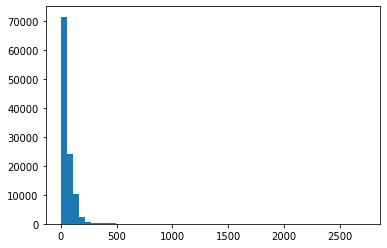

In [389]:
plt.hist(friend_weights.values, bins=50)

In [390]:
max(rowf), max(colf)

(120060, 120060)

In [392]:
train_f2u = csr_matrix((dataf, (rowf, colf)), shape=(120061, 120061))

In [393]:
als = AlternatingLeastSquares(factors=16, random_state=0)
als.fit(train_f2u)

  0%|          | 0/15 [00:00<?, ?it/s]

In [394]:
als.item_factors.shape

(120061, 16)

In [395]:
als.user_factors.shape

(120061, 16)

In [396]:
from sklearn.neighbors import KNeighborsRegressor

In [397]:
N = 10000

In [398]:
user_embs_for_knn = np.array([als.user_factors[u] for u in train['uid'].values])
knn_age = train['age'].values
user_embs_for_knn.shape, knn_age.shape

((29469, 16), (29469,))

In [399]:
def calc_embedding_by_user_friends(user_friends: np.array):
    groups_embeds = als.item_factors[user_friends]
    user_embed = np.mean(groups_embeds, axis=0)
    return user_embed

In [351]:
%%time
for x in user_embs_for_knn[N:]:
    print(float(knn.predict([x])))
    break

31.426724404225716
CPU times: user 6.27 ms, sys: 2.66 ms, total: 8.93 ms
Wall time: 2.73 ms


In [400]:
%%time
knn = KNeighborsRegressor(weights='distance', n_neighbors=25)
knn.fit(user_embs_for_knn, knn_age)

knn_age_predicted = knn.predict(user_embs_for_knn)

res = np.mean((knn_age_predicted - knn_age) ** 2) ** 0.5
res

CPU times: user 29.5 s, sys: 6.69 s, total: 36.1 s
Wall time: 17.5 s


4.1398631323867425

In [403]:
%%time

for ng in [5,10,15,20,25,50,100]:
    knn = KNeighborsRegressor(weights='distance', n_neighbors=ng)
    knn.fit(user_embs_for_knn[:N], knn_age[:N])

    knn_age_predicted = knn.predict(user_embs_for_knn[N:])

    res = np.mean((knn_age_predicted - knn_age[N:]) ** 2) ** 0.5
    print(ng, res)

5 10.627967069866244
10 10.174975948579815
15 10.13221329894644
20 10.093566655497026
25 10.090185866004456
50 10.145900310413072
100 10.230385974242639
CPU times: user 49.6 s, sys: 12.6 s, total: 1min 2s
Wall time: 31.3 s


In [404]:
known_friends = np.unique(friends2way['uid'].values)

In [405]:
pd.DataFrame(known_friends).to_csv("../submision/data/train_friends.csv", index=None, index_label=None)

In [406]:
pd.DataFrame(user_embs_for_knn).to_csv("../submision/data/train_friends_als_user_embeddings.csv", index=None, index_label=None)

In [407]:
friends_embds_for_knn = als.item_factors[known_friends]

In [408]:
pd.DataFrame(friends_embds_for_knn).to_csv("../submision/data/train_friends_als_friends_embeddings.csv", index=None, index_label=None)